In [40]:
# import necessary packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

In [21]:
# look at the data
data = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [26]:
# look at the data types
print(data.shape)
data.dtypes

(7043, 31)


SeniorCitizen                              int64
Partner                                    int64
Dependents                                 int64
tenure                                     int64
PhoneService                               int64
PaperlessBilling                           int64
MonthlyCharges                           float64
TotalCharges                             float64
Churn                                      int64
gender_Male                                 bool
MultipleLines_No phone service              bool
MultipleLines_Yes                           bool
InternetService_Fiber optic                 bool
InternetService_No                          bool
OnlineSecurity_No internet service          bool
OnlineSecurity_Yes                          bool
OnlineBackup_No internet service            bool
OnlineBackup_Yes                            bool
DeviceProtection_No internet service        bool
DeviceProtection_Yes                        bool
TechSupport_No inter

## 1. Exploratory Data Analysis to check Assumptions

### a. Assumptions of Linear Regression and Diagnostic Checks

1. Linearity: will be evaluated using a **residuals vs. fitted plot**. Since `churn` is binary, this assumption may be partially violated and results interpreted with caution.  

2. Independence of observations will be tested with the **Durbin-Watson statistic**, where values close to 2 indicate no autocorrelation.  

3. Homoscedasticity: Constant variance will be checked through a **residuals vs. fitted values plot** and confirmed with the **Breusch-Pagan test**.  

4. Normality: Residual normality will be assessed visually using a **Q-Q plot** and statistically using the **Shapiro-Wilk test**.  

5. Multicollinearity will be measured using the **Variance Inflation Factor (VIF)**. Values above 5 (or 10) will signal potential issues.  


In [22]:
# Remove customerID
data = data.drop("customerID", axis=1)

# Convert TotalCharges to numeric
data["TotalCharges"] = pd.to_numeric(data["TotalCharges"], errors="coerce")

# Impute missing TotalCharges
data["TotalCharges"] = data["TotalCharges"].fillna(data["TotalCharges"].median())

# Encode binary columns
binary_cols = ["Partner", "Dependents", "PhoneService", "PaperlessBilling", "Churn"]
for col in binary_cols:
    data[col] = data[col].map({"Yes": 1, "No": 0})

# One-hot encode categorical columns
categorical_cols = data.select_dtypes(include="object").columns
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

In [24]:
# Apply OLS regression model after feature engineering

y = data["Churn"].astype(float)  # Ensure float dtype

import statsmodels.api as sm

# Add constant for intercept and ensure all predictors are float
X_sm = sm.add_constant(data.drop("Churn", axis=1).astype(float))

# Fit OLS regression
model = sm.OLS(y, X_sm).fit()

# Print full summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Churn   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     121.2
Date:                Mon, 15 Sep 2025   Prob (F-statistic):               0.00
Time:                        02:52:14   Log-Likelihood:                -3057.9
No. Observations:                7043   AIC:                             6164.
Df Residuals:                    7019   BIC:                             6328.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

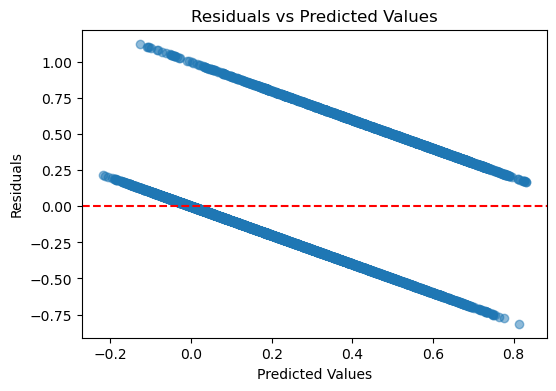

Durbin-Watson statistic: 2.005225809093518
Breusch-Pagan p-value: 1.0601451725013384e-270


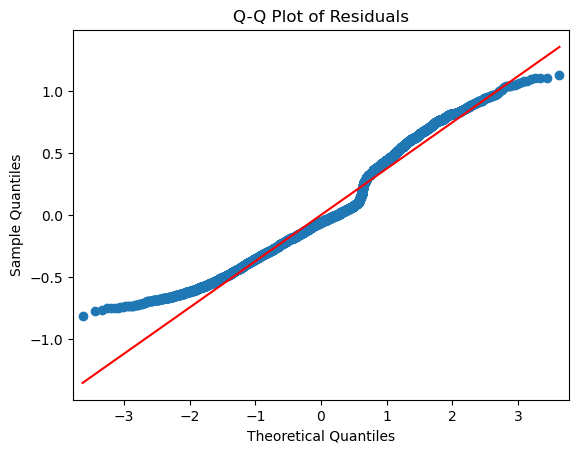

Shapiro-Wilk p-value: 1.8620208637153028e-39


/opt/miniconda3/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7043.
  res = hypotest_fun_out(*samples, **kwds)
/opt/miniconda3/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/opt/miniconda3/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Top 10 VIF values:
            VIF                               feature
24         inf   StreamingMovies_No internet service
20         inf       TechSupport_No internet service
16         inf      OnlineBackup_No internet service
5          inf                          PhoneService
18         inf  DeviceProtection_No internet service
10         inf        MultipleLines_No phone service
22         inf       StreamingTV_No internet service
13         inf                    InternetService_No
14         inf    OnlineSecurity_No internet service
7   865.066041                        MonthlyCharges


In [25]:
# Linear Regression Assumptions Diagnostics (using statsmodels OLS results)

# Residuals and fitted values
residuals = model.resid
y_pred = model.fittedvalues

# 1. Linearity & Homoscedasticity: Residual plot
plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.show()

# 2. Independence/Autocorrelation: Durbin-Watson test
from statsmodels.stats.stattools import durbin_watson

dw_stat = durbin_watson(residuals)
print("Durbin-Watson statistic:", dw_stat)

# 3. Homoscedasticity: Breusch-Pagan test
from statsmodels.stats.diagnostic import het_breuschpagan

bp_test = het_breuschpagan(residuals, X_sm)
print("Breusch-Pagan p-value:", bp_test[1])

# 4. Normality: Q-Q plot and Shapiro-Wilk test
import scipy.stats as stats

sm.qqplot(residuals, line="s")
plt.title("Q-Q Plot of Residuals")
plt.show()
shapiro_p = stats.shapiro(residuals)[1]
print("Shapiro-Wilk p-value:", shapiro_p)

# 5. Multicollinearity: VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X_sm.values, i) for i in range(X_sm.shape[1])]
vif["feature"] = X_sm.columns
print("Top 10 VIF values:\n", vif.sort_values("VIF", ascending=False).head(10))

### Linear Regression Assumption Checks

From the diagnostic tests, several assumptions of linear regression appear to be violated.  

- Linearity and Homoscedasticity: The **residuals vs. fitted plot** shows two diagonal patterns where none should appear, suggesting a violation of linearity. Typically, violations of linearity or homoscedasticity are indicated by curved or funnel-shaped patterns.  

- Independence and Autocorrelation: The **Durbin-Watson statistic** is very close to 2, indicating no autocorrelation and confirming that the observations are independent.  

- Normality: The **Q-Q plot** shows deviations from the 45-degree reference line, both at the ends and in the middle, suggesting that residuals are not normally distributed.  

- Multicollinearity: The **VIF results** include infinite or very high values, suggesting multicollinearity. Some predictors, such as `PhoneService`, showed high VIF scores and may need to be removed to improve the model.  


### b. Assumptions of Logistic Regression and Diagnostic Checks

1. Linearity of the logit: Evaluated using the **Box-Tidwell test** for continuous predictors (e.g., tenure, TotalCharges). This checks whether the relationship between each continuous predictor and the log odds of the outcome is linear. Non-significant p-values indicate the assumption is met.

2. Independence of observations: Tested with the **Durbin-Watson statistic** on deviance residuals. Values close to 2 suggest no autocorrelation and confirm independence.

3. Multicollinearity: Measured using the **Variance Inflation Factor (VIF)**. Values above 5 (or 10) indicate problematic multicollinearity among predictors, which can destabilize coefficient estimates.

4. Influential outliers: Assessed using **Cook's distance** and **studentized residuals**. High values may indicate observations that unduly influence the model fit or are strong outliers.

*Note: Homoscedasticity and normality of residuals are not required assumptions for logistic regression.*

Box-Tidwell p-value for tenure: 1.1276368859131376e-06
Box-Tidwell p-value for TotalCharges: 7.5216212413952225e-16
Durbin-Watson statistic (deviance residuals): 1.9962806793338084
Top 10 VIF values (logit, raw):
            VIF                         feature
5          inf                    PhoneService
10         inf  MultipleLines_No phone service
7   865.066041                  MonthlyCharges
12  148.263438     InternetService_Fiber optic
13  104.219371              InternetService_No
19   24.109793             StreamingMovies_Yes
18   24.056872                 StreamingTV_Yes
8    10.675411                    TotalCharges
4     7.407607                          tenure
11    7.274160               MultipleLines_Yes
Max Cook's distance: 0.004440665432510858
Max studentized residual: 18.770138491795006
Top 10 VIF values (logit, raw):
            VIF                         feature
5          inf                    PhoneService
10         inf  MultipleLines_No phone service
7   865.

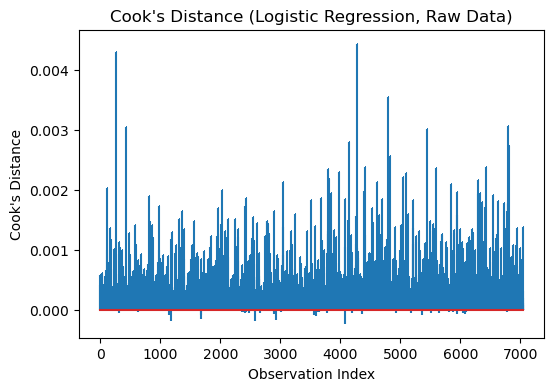

In [41]:
# Logistic Regression Assumptions Diagnostics (raw data, drop constant and duplicate columns)
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant

# Prepare features and target from raw data
X_logit_raw = data.drop("Churn", axis=1)
y_logit_raw = (
    data["Churn"].map({"Yes": 1, "No": 0})
    if data["Churn"].dtype == object
    else data["Churn"]
)
X_logit_raw = pd.get_dummies(X_logit_raw, drop_first=True)
X_logit_raw = X_logit_raw.apply(pd.to_numeric, errors="coerce")
y_logit_raw = pd.to_numeric(y_logit_raw, errors="coerce")

# Drop constant columns (zero variance)
X_logit_raw = X_logit_raw.loc[:, X_logit_raw.nunique() > 1]

# Drop duplicate columns
X_logit_raw = X_logit_raw.T.drop_duplicates().T

X_logit_const_raw = add_constant(X_logit_raw)

# Drop any rows with missing values to avoid dtype issues
X_logit_const_raw = X_logit_const_raw.dropna()
y_logit_raw = y_logit_raw.loc[X_logit_const_raw.index]

# Ensure all columns are float
X_logit_const_raw = X_logit_const_raw.astype(float)
y_logit_raw = y_logit_raw.astype(float)

# Fit logistic regression
logit_model_raw = Logit(y_logit_raw, X_logit_const_raw).fit(disp=0)

# 1. Linearity of predictors with logit (Box-Tidwell test for continuous variables)
from scipy.stats import norm

continuous_vars = [
    var for var in ["tenure", "TotalCharges"] if var in X_logit_const_raw.columns
]
for var in continuous_vars:
    X_logit_const_raw[var + "_log"] = X_logit_const_raw[var] * np.log(
        X_logit_const_raw[var] + 1
    )
    box_tidwell_model = Logit(
        y_logit_raw, X_logit_const_raw[["const", var, var + "_log"]]
    ).fit(disp=0)
    print(f"Box-Tidwell p-value for {var}:", box_tidwell_model.pvalues[var + "_log"])
    X_logit_const_raw = X_logit_const_raw.drop(columns=[var + "_log"])

# 2. Independence of observations (Durbin-Watson test on deviance residuals)
from statsmodels.stats.stattools import durbin_watson

deviance_resid = logit_model_raw.resid_dev
print("Durbin-Watson statistic (deviance residuals):", durbin_watson(deviance_resid))

# 3. Multicollinearity (VIF)
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_logit_raw = pd.DataFrame()
vif_logit_raw["VIF"] = [
    variance_inflation_factor(X_logit_const_raw.values, i)
    for i in range(X_logit_const_raw.shape[1])
]
vif_logit_raw["feature"] = X_logit_const_raw.columns
print(
    "Top 10 VIF values (logit, raw):\n",
    vif_logit_raw.sort_values("VIF", ascending=False).head(10),
)

# 4. Influential outliers (Cook's distance, studentized residuals)
influence = logit_model_raw.get_influence()
cooks_d = influence.cooks_distance[0]
studentized_resid = influence.resid_studentized
print("Max Cook's distance:", np.max(cooks_d))
print("Max studentized residual:", np.max(studentized_resid))
plt.figure(figsize=(6, 4))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",")
plt.title("Cook's Distance (Logistic Regression, Raw Data)")
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.show()

### Logistic Regression Assumption Checks

From the diagnostic tests, several assumptions of logistic regression appear to be violated or require attention.

- **Linearity of the logit:** The Box-Tidwell p-values for both `tenure` (1.13e-06) and `TotalCharges` (7.52e-16) are highly significant, indicating a violation of the linearity assumption for these continuous predictors. This suggests that the relationship between these variables and the log odds of churn is not strictly linear, and model results should be interpreted with caution or consider transformation of these predictors.

- **Independence of observations:** The Durbin-Watson statistic for deviance residuals is 1.996, which is very close to 2. This indicates no autocorrelation and confirms that the observations are independent.

- **Multicollinearity:** The VIF results show extremely high values, including infinite VIFs for `PhoneService` and `MultipleLines_No phone service`, and very high VIFs for other predictors such as `MonthlyCharges`, `InternetService_Fiber optic`, and `InternetService_No`. This indicates severe multicollinearity, which can destabilize coefficient estimates and make interpretation unreliable. Highly collinear variables should be removed or combined to improve model validity.

- **Influential outliers:** The maximum Cook's distance is very low (0.0044), suggesting no single observation is unduly influencing the model. However, the maximum studentized residual is very high (18.77), indicating the presence of strong outliers. These cases should be investigated for data entry errors or special circumstances.


### c. GAM Assumptions and Diagnostic Checks

1. **Additivity of predictors**: Check estimated smooth functions to ensure each predictor contributes additively. Add interaction terms explicitly if non-additive effects are suspected.

2. **Correct link function and response distribution**: Ensure the link function (e.g., logit for binary, log for counts) matches the response. Compare model fit with alternatives if necessary.

3. **Independence of observations**: Plot residuals against observation order or use the Durbin-Watson statistic for time-ordered data. Values near 2 indicate no autocorrelation.

4. **Smoothness / function form**: Inspect smooth functions visually. Overly wiggly curves may indicate overfitting; under-smoothed curves may miss patterns. Use GCV or REML to select smoothness.

5. **No perfect multicollinearity**: Use correlation matrices or VIF to check predictors and smooth terms. High correlation can destabilize estimation.

6. **No overly influential outliers**: Examine deviance residuals, Cook's distance, or leverage plots to identify observations that strongly influence smooth estimates.

*Note: Linearity, homoscedasticity, and normality of residuals are not required for GAMs with non-Gaussian responses.*


## 2. Linear Regression

In [32]:
# List of high VIF variables to remove
high_vif_vars = [
    "PhoneService",
    "MonthlyCharges",
    "MultipleLines_No phone service",
    "InternetService_No",
    "OnlineSecurity_No internet service",
    "OnlineBackup_No internet service",
    "DeviceProtection_No internet service",
    "TechSupport_No internet service",
    "StreamingTV_No internet service",
    "StreamingMovies_No internet service",
]

# Remove these columns from your DataFrame
X_reduced = data.drop(high_vif_vars + ["Churn"], axis=1)
y = data["Churn"].astype(float)

import statsmodels.api as sm

X_sm_reduced = sm.add_constant(X_reduced.astype(float))
model_reduced = sm.OLS(y, X_sm_reduced).fit()
print(model_reduced.summary())

                            OLS Regression Results                            
Dep. Variable:                  Churn   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.273
Method:                 Least Squares   F-statistic:                     133.5
Date:                Mon, 15 Sep 2025   Prob (F-statistic):               0.00
Time:                        03:42:16   Log-Likelihood:                -3101.1
No. Observations:                7043   AIC:                             6244.
Df Residuals:                    7022   BIC:                             6388.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [33]:
# R-squared and Adjusted R-squared
print("R-squared:", model_reduced.rsquared)
print("Adjusted R-squared:", model_reduced.rsquared_adj)

# Mean Squared Error and RMSE
from sklearn.metrics import mean_squared_error

y_pred = model_reduced.fittedvalues
mse = mean_squared_error(y, y_pred)
rmse = mse**0.5
print("MSE:", mse)
print("RMSE:", rmse)

R-squared: 0.2754800644678984
Adjusted R-squared: 0.27341649301950166
MSE: 0.14124422134464082
RMSE: 0.3758247215719594


## Interpretation of Regression Coefficients

### Significant Predictors

- SeniorCitizen (0.051, p < 0.001): Being a senior citizen increases churn probability by about 5 percentage points, and this effect is statistically significant.  
- Dependents (-0.024, p = 0.036): Having dependents lowers churn probability by about 2.4 percentage points.  
- Tenure (-0.002, p < 0.001): Each additional month with the company slightly reduces churn (about 0.2 percentage points per month).  
- PaperlessBilling (0.056, p < 0.001): Customers using paperless billing are about 5.6 percentage points more likely to churn.  
- TotalCharges (-0.000043, p < 0.001): Higher total charges are associated with slightly lower churn, consistent with longer customer relationships.  
- MultipleLines_Yes (0.045, p < 0.001): Having multiple phone lines increases churn by 4.5 percentage points.  
- InternetService_Fiber optic (0.194, p < 0.001): Fiber optic customers are much more likely to churn, with churn probability increasing by nearly 19 percentage points compared to DSL/no internet.  
- StreamingTV_Yes (0.062, p < 0.001): Streaming TV increases churn by 6.2 percentage points.  
- StreamingMovies_Yes (0.066, p < 0.001): Streaming movies increases churn by 6.6 percentage points.  
- Contract_One year (-0.132, p < 0.001): One-year contracts reduce churn by 13 percentage points compared to month-to-month.  
- Contract_Two year (-0.115, p < 0.001): Two-year contracts reduce churn by 11.5 percentage points.  
- PaymentMethod_Electronic check (0.077, p < 0.001): Customers paying by electronic check are about 7.7 percentage points more likely to churn.  

### Not Significant Predictors

- Partner (-0.002, p = 0.889): No significant relationship between having a partner and churn.  
- Gender_Male (-0.002, p = 0.821): Gender does not significantly affect churn.  
- OnlineSecurity_Yes (-0.017, p = 0.152): Not significant, though direction suggests reduced churn.  
- OnlineBackup_Yes (0.004, p = 0.755): No significant effect.  
- DeviceProtection_Yes (0.018, p = 0.125): No significant effect.  
- TechSupport_Yes (-0.022, p = 0.066): Slightly below significance threshold; may reduce churn but evidence is weak.  
- PaymentMethod_Credit card (automatic) (-0.006, p = 0.639): No significant effect.  
- PaymentMethod_Mailed check (-0.022, p = 0.132): No significant effect.  

## Model Performance Interpretation

- **R-squared (0.275)**: About 27.5% of the variation in churn is explained by the predictors in the reduced model. This indicates that while the model captures some meaningful relationships, a large portion of variability remains unexplained.  

- **Adjusted R-squared (0.273)**: The adjusted value, which accounts for the number of predictors, is very close to the regular R-squared. This suggests that the included predictors contribute useful information and that overfitting is limited.  

- **MSE (0.141)**: The mean squared error shows the average squared difference between observed and predicted churn probabilities. Since churn is binary (0/1), the maximum possible squared error is 1. An MSE of 0.141 means the model’s predictions are wrong by about 14% of the maximum possible error. This is better than random guessing but still indicates room for improvement.  

- **RMSE (0.376)**: On average, the model’s predicted churn probabilities deviate from the actual values by about 0.376 (on a 0–1 scale). This suggests the model has some predictive power beyond chance, but the prediction errors remain relatively large.  


## 3. Logistic Regression

In [44]:
# Logistic Regression after removing high VIF variables
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant

# List of high VIF variables to remove (based on previous diagnostics)
high_vif_vars = [
    "PhoneService",
    "MultipleLines_No phone service",
    "MonthlyCharges",
    "InternetService_Fiber optic",
    "InternetService_No",
    "StreamingMovies_Yes",
    "StreamingTV_Yes",
    "TotalCharges",
    "tenure",
    "MultipleLines_Yes",
]

# Prepare features and target
data_for_logit = data.copy()
X_logit_reduced = data_for_logit.drop(high_vif_vars + ["Churn"], axis=1)
X_logit_reduced = pd.get_dummies(X_logit_reduced, drop_first=True)
X_logit_reduced = X_logit_reduced.apply(pd.to_numeric, errors="coerce")

# Drop constant columns (zero variance)
X_logit_reduced = X_logit_reduced.loc[:, X_logit_reduced.nunique() > 1]

# Drop duplicate columns
X_logit_reduced = X_logit_reduced.T.drop_duplicates().T

y_logit_reduced = (
    data_for_logit["Churn"].map({"Yes": 1, "No": 0})
    if data_for_logit["Churn"].dtype == object
    else data_for_logit["Churn"]
)
y_logit_reduced = pd.to_numeric(y_logit_reduced, errors="coerce")

# Add constant and drop missing values
X_logit_const_reduced = add_constant(X_logit_reduced)
X_logit_const_reduced = X_logit_const_reduced.dropna()
y_logit_reduced = y_logit_reduced.loc[X_logit_const_reduced.index]

# Ensure all columns are float
y_logit_reduced = y_logit_reduced.astype(float)
X_logit_const_reduced = X_logit_const_reduced.astype(float)

# Fit logistic regression
logit_model_reduced = Logit(y_logit_reduced, X_logit_const_reduced).fit(disp=0)
print(logit_model_reduced.summary())

                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 7043
Model:                          Logit   Df Residuals:                     7027
Method:                           MLE   Df Model:                           15
Date:                Mon, 15 Sep 2025   Pseudo R-squ.:                  0.2399
Time:                        04:34:30   Log-Likelihood:                -3097.3
converged:                       True   LL-Null:                       -4075.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -0.3368      0.111     -3.045      0.002      -0.554      -0.120
SeniorCitizen                             0.2281  

Confusion Matrix:
 [[4589  585]
 [ 938  931]]
Accuracy: 0.7837569217662927
Precision: 0.6141160949868074
Recall: 0.49812734082397003
F1 Score: 0.5500738552437223
ROC AUC: 0.8233228950862059


Confusion Matrix:
 [[4589  585]
 [ 938  931]]
Accuracy: 0.7837569217662927
Precision: 0.6141160949868074
Recall: 0.49812734082397003
F1 Score: 0.5500738552437223
ROC AUC: 0.8233228950862059


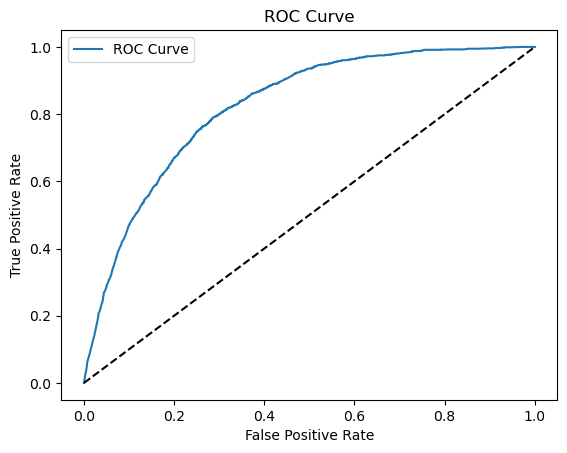

In [45]:
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
)
import matplotlib.pyplot as plt

# Predict probabilities and classes
y_pred_prob = logit_model_reduced.predict(X_logit_const_reduced)
y_pred_class = (y_pred_prob > 0.5).astype(int)

# Confusion matrix and metrics
print("Confusion Matrix:\n", confusion_matrix(y_logit_reduced, y_pred_class))
print("Accuracy:", accuracy_score(y_logit_reduced, y_pred_class))
print("Precision:", precision_score(y_logit_reduced, y_pred_class))
print("Recall:", recall_score(y_logit_reduced, y_pred_class))
print("F1 Score:", f1_score(y_logit_reduced, y_pred_class))
print("ROC AUC:", roc_auc_score(y_logit_reduced, y_pred_prob))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_logit_reduced, y_pred_prob)
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

## Interpretation of Logistic Regression Coefficients

### Significant Predictors

- SeniorCitizen (0.228, p = 0.005): Being a senior citizen increases the log-odds of churn by 0.228. This corresponds to higher probability of churn for senior citizens compared to non-seniors.  
- Partner (-0.154, p = 0.035): Having a partner decreases the log-odds of churn by 0.154, meaning partnered customers are less likely to churn.  
- Dependents (-0.189, p = 0.029): Having dependents reduces the log-odds of churn by 0.189, indicating a lower churn probability.  
- PaperlessBilling (0.432, p < 0.001): Using paperless billing increases the log-odds of churn by 0.432, showing higher churn likelihood.  
- OnlineSecurity_No internet service (-1.480, p < 0.001): Customers without internet service have much lower log-odds of churn compared to the reference group.  
- OnlineSecurity_Yes (-0.626, p < 0.001): Customers with online security have lower log-odds of churn than those without, reducing churn probability.  
- OnlineBackup_Yes (-0.331, p < 0.001): Having online backup reduces log-odds of churn, suggesting a protective effect.  
- TechSupport_Yes (-0.460, p < 0.001): Access to tech support lowers the log-odds of churn.  
- Contract_One year (-1.194, p < 0.001): One-year contracts strongly decrease the log-odds of churn relative to month-to-month contracts.  
- Contract_Two year (-2.195, p < 0.001): Two-year contracts provide the largest reduction in churn log-odds, indicating a very strong protective effect.  
- PaymentMethod_Electronic check (0.541, p < 0.001): Paying via electronic check increases log-odds of churn, raising the probability of leaving compared to automatic bank transfer.

### Not Significant Predictors

- Gender_Male (-0.052, p = 0.402): No significant effect on churn probability.  
- DeviceProtection_Yes (-0.025, p = 0.735): Not significant.  
- PaymentMethod_Credit card (automatic) (-0.100, p = 0.365): No significant effect on churn.  
- PaymentMethod_Mailed check (0.072, p = 0.505): No significant effect on churn.


## Logistic Regression model performance 

- ROC AUC is above 0.7, indicating the model separates churners from non-churners better than random.
- The model predicts churn with moderate accuracy, precision, and recall.
- About half of actual churners are identified; some are missed (false negatives) and some non-churners are incorrectly flagged (false positives).


## 4. Generalized Additive Model (GAM)

In [49]:
# Install pygam if not already installed
try:
    from pygam import LogisticGAM, s
except ImportError:
    !pip install pygam
    from pygam import LogisticGAM, s

from functools import reduce
from operator import add

# Remove high VIF variables (same as logistic regression reduced set)
high_vif_vars = [
    "PhoneService",
    "MultipleLines_No phone service",
    "MonthlyCharges",
    "InternetService_Fiber optic",
    "InternetService_No",
    "StreamingMovies_Yes",
    "StreamingTV_Yes",
    "TotalCharges",
    "tenure",
    "MultipleLines_Yes",
]

# Prepare features and target
data_for_gam = data.copy()
X_gam = data_for_gam.drop(high_vif_vars + ["Churn"], axis=1)
X_gam = pd.get_dummies(X_gam, drop_first=True)
X_gam = X_gam.apply(pd.to_numeric, errors="coerce")
X_gam = X_gam.loc[:, X_gam.nunique() > 1]  # Drop constant columns
X_gam = X_gam.T.drop_duplicates().T        # Drop duplicate columns
X_gam = X_gam.dropna()                     # Drop missing values

y_gam = data_for_gam["Churn"]
if y_gam.dtype == object:
    y_gam = y_gam.map({"Yes": 1, "No": 0})
y_gam = pd.to_numeric(y_gam, errors="coerce")
y_gam = y_gam.loc[X_gam.index].astype(int)

# Fit a logistic GAM with the correct number of spline terms
n_features = X_gam.shape[1]
terms = reduce(add, [s(i) for i in range(n_features)])
gam = LogisticGAM(terms).fit(X_gam.values, y_gam.values)

# Print summary
print(gam.summary())

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                        16.0
Link Function:                        LogitLink Log Likelihood:                                  -3097.297
Number of Samples:                         7043 AIC:                                             6226.5941
                                                AICc:                                            6226.6812
                                                UBRE:                                               2.8859
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2399
Feature Function                  Lam

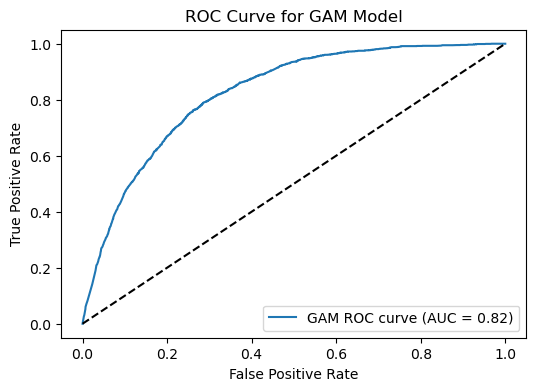

In [53]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Predict probabilities
y_gam_prob = gam.predict_proba(X_gam)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_gam, y_gam_prob)
auc = roc_auc_score(y_gam, y_gam_prob)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"GAM ROC curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for GAM Model")
plt.legend()
plt.show()

## Interpretation of GAM
- There is not a single coefficient per feature. Instead, each feature’s effect is a curve (the smooth function).
- The Area Under the Curve (AUC) is 0.82, indicating good predictive performance. An AUC above 0.8 suggests the model is effective at distinguishing between the two classes.

## 5. Model Comparison:
### Interpretability:
### Flexibility and assumptions: 

### Model Comparison: Interpretability, Flexibility, and Assumptions

Linear Regression
- Interpretability: Highly interpretable; each coefficient shows the expected change in churn probability for a one-unit change in the predictor, holding others constant.
- Assumptions: Requires linearity, homoscedasticity, normality of residuals, and no multicollinearity. Many of these were violated in the churn dataset (e.g., non-normal residuals, high VIFs).
- Flexibility: Limited; only captures linear relationships. Not suitable for binary outcomes or complex, non-linear effects.

Logistic Regression
- Interpretability: Moderately interpretable; coefficients represent changes in the log-odds of churn. Odds ratios can be calculated for practical interpretation.
- Assumptions: Requires linearity of the logit for continuous predictors, independence of observations, and no multicollinearity. Some violations were observed (e.g., Box-Tidwell test failed for tenure and TotalCharges, high VIFs).
- Flexibility: More flexible than linear regression for binary outcomes, but still assumes linear effects on the logit scale and cannot capture non-linearities without transformation.

Generalized Additive Model (GAM)
- Interpretability: Harder to interpret due to complex smooth functions.
- Assumptions: Requires additivity of predictors, correct link function, independence, and smoothness. Does not require strict linearity or normality. Multicollinearity should still be avoided.
- Flexibility: Highly flexible; can model complex, non-linear relationships and interactions. Well-suited for binary outcomes and datasets where linearity is violated.

Performance Summary:
- Linear regression explained ~27% of churn variation (R-squared = 0.27) but violated key assumptions.
- Logistic regression and GAM achieved similar ROC AUC = 0.82, showing strong predictive performance and better handling of non-linear effects.

Conclusion and Recommendation:
Logistic regression strikes a balance between flexibility and performance. It does not violate as many assumptions as linear regression, performs similarly to GAM, and remains interpretable. So I would recommend the telecommunications company to use Logistic Regression model over others. 


### References 
- The texts were edited and polished using GPT-5 on 09/14/2025 10 pm
- Snippet of code for GAM was generated using GPT 4.1 and was modified further on 09/14/2025 11 pm